In [1]:
# Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost

In [2]:
# Read Data files
df_data = pd.read_csv('modified.csv')
df_data.head()

,user,first_open,dayofweek,hour,age,screen_list,numscreens,minigame,used_premium_feature,enrolled,...,Login,ProfileEmploymentLength,WebView,SecurityModal,Loan4,ResendToken,TransactionList,NetworkFailure,ListPicker,hour_modified
0,235136,2012-12-27 02:14:51.273,3,02:00:00,23,"idscreen,joinscreen,Cycle,product_review,ScanP...",15,0,0,0,...,1,0,0,0,0,0,0,0,0,20000
1,333588,2012-12-02 01:16:00.905,6,01:00:00,24,"joinscreen,product_review,product_review2,Scan...",13,0,0,0,...,0,0,0,0,0,0,0,0,0,10000
2,254414,2013-03-19 19:19:09.157,1,19:00:00,23,"Splash,Cycle,Loan",3,0,1,0,...,0,0,0,0,0,0,0,0,0,190000
3,234192,2013-07-05 16:08:46.354,4,16:00:00,28,"product_review,Home,product_review,Loan3,Finan...",40,0,0,1,...,0,0,0,0,0,0,0,0,0,160000
4,51549,2013-02-26 18:50:48.661,1,18:00:00,31,"idscreen,joinscreen,Cycle,Credit3Container,Sca...",32,0,0,1,...,0,0,0,0,0,0,0,0,0,180000


In [3]:
#Creating X and Y datasets
#a = df_data.iloc[:,:-1] --- Could have used this form also
temp = df_data
X = temp.drop(['user','first_open','screen_list','enrolled',
               'enrolled_date','hour_modified'], axis = 1)
y = df_data.loc[:,['enrolled']]

In [4]:
#Creating dummy variables
X = pd.get_dummies(X, columns = ['hour'], drop_first = True)
del(temp)


In [5]:
#Spliting the dataset into test and training set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)


In [6]:
#Applying Dimension Reduction - Principal Component Analysis(PCA)
from sklearn.decomposition import PCA
pca = PCA(n_components = 10)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

### XGBoost Classifier

In [7]:
from xgboost import XGBClassifier
classifier = XGBClassifier()
classifier.fit(X_train, y_train)

C:\Users\aggar\Anaconda3\envs\MachineLearning\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\aggar\Anaconda3\envs\MachineLearning\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

### K-fold Cross Validation

In [8]:
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = classifier, 
                             X = X_train,
                             y = y_train,
                             scoring = 'accuracy',
                             cv = 10)
print(accuracies.mean())
print(accuracies.std())

C:\Users\aggar\Anaconda3\envs\MachineLearning\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\aggar\Anaconda3\envs\MachineLearning\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.7301747022343564
0.007630870505248186


### Test Set

In [10]:
#Predict on TEST set
y_pred = classifier.predict(X_test)

from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test,y_pred)
print(confusion_matrix)

from sklearn.metrics import accuracy_score
acc = accuracy_score(y_test, y_pred)
print('Accuracy of train set is {0}'.format(acc))

[[2314 1515]
 [1185 4986]]
Accuracy of train set is 0.73


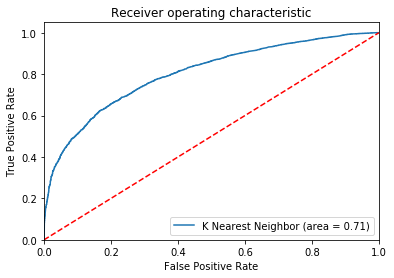

In [11]:
#ROC Curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, y_pred)
fpr, tpr, thresholds = roc_curve(y_test, classifier.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='K Nearest Neighbor (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()